# Optimizing AI Trading Algorithms - Course Project


In this project you will practice optimizing various aspects of a machine learning model for predicting stock price movements. This will provide you with an opportunity to integrate the concepts covered in the course, such as data preprocessing and cleaning, hyperparameter tuning, detecting and addressing over-/under-fitting, model evaluation, and feature selection techniques. While you will use real-world data in this project, the goal is not necessarily to build a "winning" trading _strategy_. The goal of this course has been to equip you with the tools, techniques, concepts and insights you need to evaluate, optimize and monitor *your own* trading strategies.


## The Scenario

You are an analyst at a boutique investment firm tasked with coming up with a novel idea for investing in specific sectors of the industry. You've heard that the Utilities, Consumer Staples and Healthcare sectors are relatively resilient to economic shocks and recessions, and that stock market investors tend to flock to these sectors in times of uncertainty. You decide to take the [SPDR Healthcase Sector ETF (NYSEARCA: XLV)](https://www.sectorspdrs.com/mainfund/XLV) and try to model its returns' dynamics using a machine learning AI strategy. Your novel idea is to get data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) as a proxy for uncertainty in the market. You also decide to take a look at [Google Trends data](https://trends.google.com/trends/explore?date=all&geo=US&q=recession) for the search term "recession" in the United States, in order to try and see if there is any meaningful relationship between the general public's level of concern about a recession happening and the price movements of the Health Care Select Sector SPDR Fund.


You decide to train a binary **classification** model that merely attempts to predict the **direction** of XLV's 5-day price movements. In other words, you want to see if on any given day, with the above data in hand, you could reliably predict whether the price of XLV will increase or decrease over the next 5 trading days.

Run the cell below to `import` all the Python packages and modules you will be using throughout the project.

In [1]:
#!pip install --upgrade pip yfinance ta --quiet

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

RANDOM_SEED = 42

## 1. Data Acquisition, Exploration, Cleaning and Preprocessing


In this section, you will download and inspect:

- daily data for the SPDR Healthcase Sector ETF (NYSEARCA: XLV)
- daily data for the volatility index (INDEXCBOE: VIX)
- monthly data from Google Trends for the search interest in the term "recession" in the United States

The goal is to make sure the data is clean, meaningful, and usable for selecting and engineering features.


### 1.1. Price and Volume Data for "XLV"


We have downloded daily data from **January 1st, 2004** to **March 31st, 2024** for the ticker **XLV** using the `yfinance` library and stored it in a CSV file named `xlv_data.csv`. Load this data into a Pandas DataFrame named `xlv_data`, making sure to set the index column to the first column of the CSV file (`Date`) and set `parse_dates=True`.


In [3]:
xlv_data = pd.read_csv('xlv_data.csv', parse_dates=True)
xlv_data.set_index('Date', inplace=True)
xlv_data.index = pd.to_datetime(xlv_data.index)
print(xlv_data)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-01-02   30.200001   30.440001   30.120001   30.219999   21.567184   
2004-01-05   30.400000   30.500000   30.139999   30.360001   21.667091   
2004-01-06   30.469999   30.480000   30.309999   30.450001   21.731337   
2004-01-07   30.450001   30.639999   30.309999   30.639999   21.866926   
2004-01-08   30.700001   30.700001   30.320000   30.510000   21.774158   
...                ...         ...         ...         ...         ...   
2024-03-22  145.850006  146.220001  145.259995  145.440002  145.440002   
2024-03-25  145.710007  145.860001  145.009995  145.240005  145.240005   
2024-03-26  145.529999  145.940002  145.139999  145.770004  145.770004   
2024-03-27  147.009995  147.710007  146.619995  147.710007  147.710007   
2024-03-28  147.919998  148.229996  147.679993  147.729996  147.729996   

             Volume  
Date           

Use the `info()` and `describe()` methods to get an overview of how many rows of data there are in `xlv_data`, what columns are present and what their data types are, and what some basic statistics (mean, std, quartiles, min/max values) of the columns look like.


In [4]:
xlv_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 2004-01-02 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5094 non-null   float64
 1   High       5094 non-null   float64
 2   Low        5094 non-null   float64
 3   Close      5094 non-null   float64
 4   Adj Close  5094 non-null   float64
 5   Volume     5094 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 278.6 KB


In [5]:
xlv_data.describe()

Open         High          Low        Close    Adj Close  \
count  5094.000000  5094.000000  5094.000000  5094.000000  5094.000000   
mean     65.342311    65.730397    64.924197    65.349097    58.242299   
std      36.695351    36.915853    36.477869    36.712468    37.932219   
min      22.010000    22.290001    21.629999    21.879999    16.812475   
25%      31.990000    32.132501    31.812500    31.990000    24.508568   
50%      57.100000    57.400000    56.680000    57.010000    48.387001   
75%      90.657503    91.077497    89.927500    90.557499    82.941315   
max     147.919998   148.270004   147.679993   147.860001   147.729996   

             Volume  
count  5.094000e+03  
mean   7.228951e+06  
std    5.445803e+06  
min    5.870000e+04  
25%    3.790550e+06  
50%    6.582850e+06  
75%    9.559550e+06  
max    6.647020e+07

How many `NaN` rows are there in `xlv_data`?


In [6]:
answer = xlv_data.isna().sum()
answer

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Take a look at the final five rows of `xlv_data`.


In [7]:
xlv_data.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-03-22  145.850006  146.220001  145.259995  145.440002  145.440002   
2024-03-25  145.710007  145.860001  145.009995  145.240005  145.240005   
2024-03-26  145.529999  145.940002  145.139999  145.770004  145.770004   
2024-03-27  147.009995  147.710007  146.619995  147.710007  147.710007   
2024-03-28  147.919998  148.229996  147.679993  147.729996  147.729996   

             Volume  
Date                 
2024-03-22  5537200  
2024-03-25  5253000  
2024-03-26  6942400  
2024-03-27  8797400  
2024-03-28  8090200

Raw OHLC data is not suitable for training models. The absolute price level of a security is boundless in theory and not particularly menaningful. In the next section, you are going to engineer useful features from all of these columns. For now, as a visual sanity check, plot `Adj Close` as a line plot.


<Axes: title={'center': 'XLV Adj Close Price'}, xlabel='Date'>

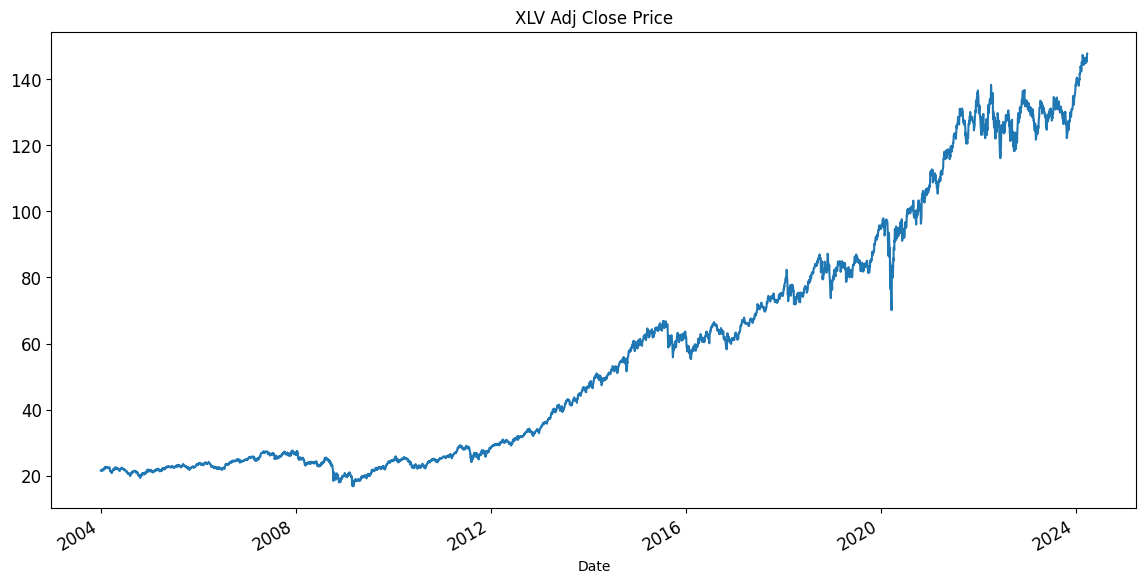

In [8]:
xlv_data["Adj Close"].plot(figsize=(14, 7), title="XLV Adj Close Price", fontsize=12)

**Bonus**: The cell below plots the combined candlestick + volume chart for the last 15 months of data using Plotly.


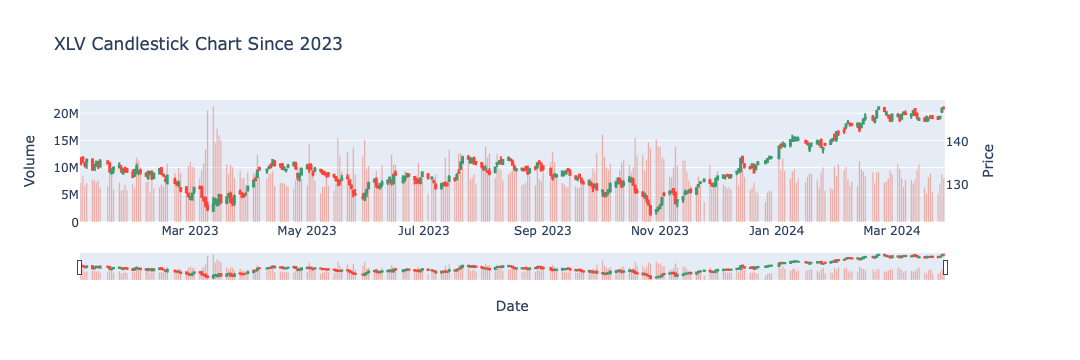

In [9]:
data_since_2023 = xlv_data["2023-01-01":]

figure = make_subplots(specs=[[{"secondary_y": True}]])
figure.add_traces(
    go.Candlestick(
        x=data_since_2023.index,
        open=data_since_2023.Open,
        high=data_since_2023.High,
        low=data_since_2023.Low,
        close=data_since_2023.Close,
    ),
    secondary_ys=[True],
)
figure.add_traces(
    go.Bar(x=data_since_2023.index, y=data_since_2023.Volume, opacity=0.5),
    secondary_ys=[False],
)

figure.update_layout(
    title="XLV Candlestick Chart Since 2023",
    xaxis_title="Date",
    yaxis_title="Volume",
    yaxis2_title="Price",
    showlegend=False,
)
figure.update_yaxes(fixedrange=False)
figure.layout.yaxis2.showgrid = False
figure.show()

### 1.2. Data for The Volatility Index `VIX`


As before, we have downloaded daily data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) over the same time period using `yfinance` and provided it to you in a CSV file named `vix_data.csv`. Load the data into a variable named `vix_data`. Make sure to set the index and parse the dates correctly.


In [10]:
vix_data = pd.read_csv('vix_data.csv', parse_dates=True)
vix_data.set_index('Date', inplace=True)
vix_data.index = pd.to_datetime(vix_data.index)
vix_data

Open   High        Low      Close  Adj Close  Volume
Date                                                                 
2004-01-02  17.959999  18.68  17.540001  18.219999  18.219999       0
2004-01-05  18.450001  18.49  17.440001  17.490000  17.490000       0
2004-01-06  17.660000  17.67  16.190001  16.730000  16.730000       0
2004-01-07  16.719999  16.75  15.500000  15.500000  15.500000       0
2004-01-08  15.420000  15.68  15.320000  15.610000  15.610000       0
...               ...    ...        ...        ...        ...     ...
2024-03-22  12.920000  13.15  12.580000  13.060000  13.060000       0
2024-03-25  13.670000  13.67  13.110000  13.190000  13.190000       0
2024-03-26  13.120000  13.43  12.840000  13.240000  13.240000       0
2024-03-27  13.130000  13.34  12.660000  12.780000  12.780000       0
2024-03-28  12.930000  13.10  12.840000  13.010000  13.010000       0

[5094 rows x 6 columns]

Plot a line chart of the `Adj Close` value of the VIX using your method of choice (e.g. `plotly` or `matplotlib`).


<Axes: title={'center': 'VIX Adj Close Price'}, xlabel='Date'>

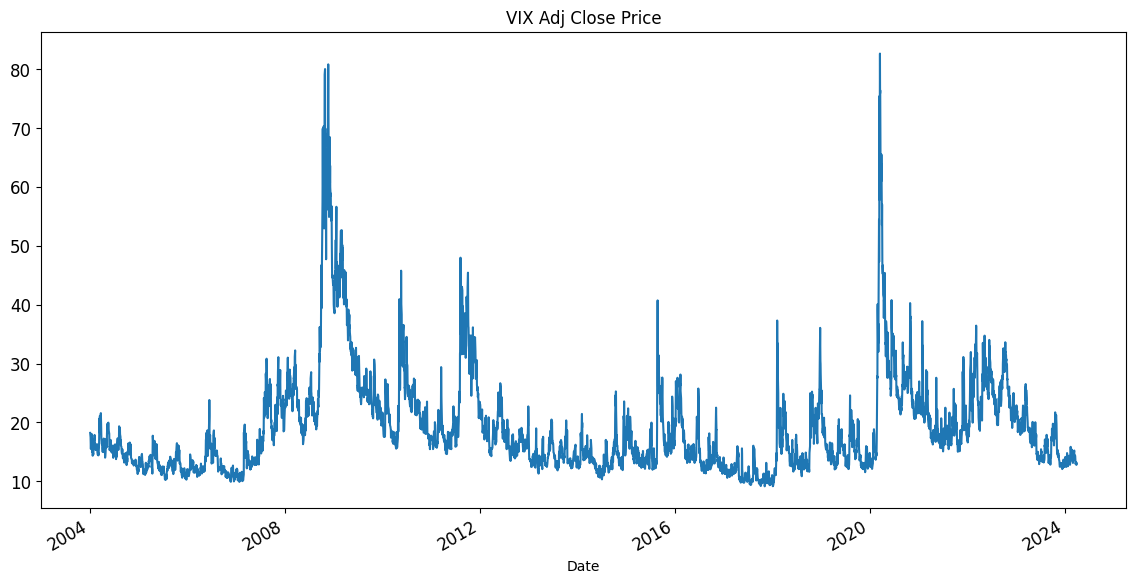

In [11]:
vix_data["Adj Close"].plot(figsize=(14, 7), title="VIX Adj Close Price", fontsize=12)

### 1.3. Google Trends Data


The **monthly** evolution of search interest in the term "recession" in the U.S. over the period of interest (Jan. 2003 - Mar. 2024) from the Google Trends website has been provided to you as a CSV file. We will load this data using Pandas into a DataFrame named `google_trends_data`, set the index column of the DataFrame to the "`Month`" column from the CSV and have Pandas try and parse these dates automatically.

> Note: The "Month" column in the CSV is in "YYYY-MM" format.


In [12]:
google_trends_data = pd.read_csv('GoogleTrendsData.csv', parse_dates=True)
google_trends_data.set_index('Month', inplace=True)
google_trends_data.index = pd.to_datetime(google_trends_data.index)
google_trends_data

recession_search_trend
Month                             
2004-01-01                       4
2004-02-01                       4
2004-03-01                       5
2004-04-01                       6
2004-05-01                       4
...                            ...
2023-11-01                      16
2023-12-01                      13
2024-01-01                      12
2024-02-01                      16
2024-03-01                      13

[243 rows x 1 columns]

As noted above, the CSV lists **monthly** search trends data and the `Month` column is in YYYY-MM format. How has Pandas interpreted and parsed these into specific dates? Take a look at `google_trends_data`'s index.


In [13]:
google_trends_data.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01',
               '2024-02-01', '2024-03-01'],
              dtype='datetime64[ns]', name='Month', length=243, freq=None)

We would have liked to assign the data points to the last day of the respective months, as this data would have been available at the _end_ of each period. Shift the index column of `google_trends_data` to do this.

> Hint: You can use `pd.offsets.MonthEnd()` from Pandas.


In [14]:
google_trends_data.index = google_trends_data.index.to_series().apply(pd.offsets.MonthEnd().rollback)
google_trends_data

recession_search_trend
Month                             
2003-12-31                       4
2004-01-31                       4
2004-02-29                       5
2004-03-31                       6
2004-04-30                       4
...                            ...
2023-10-31                      16
2023-11-30                      13
2023-12-31                      12
2024-01-31                      16
2024-02-29                      13

[243 rows x 1 columns]

Run the cell below to visualize this data as a line plot.

> **Note from Google:** "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."


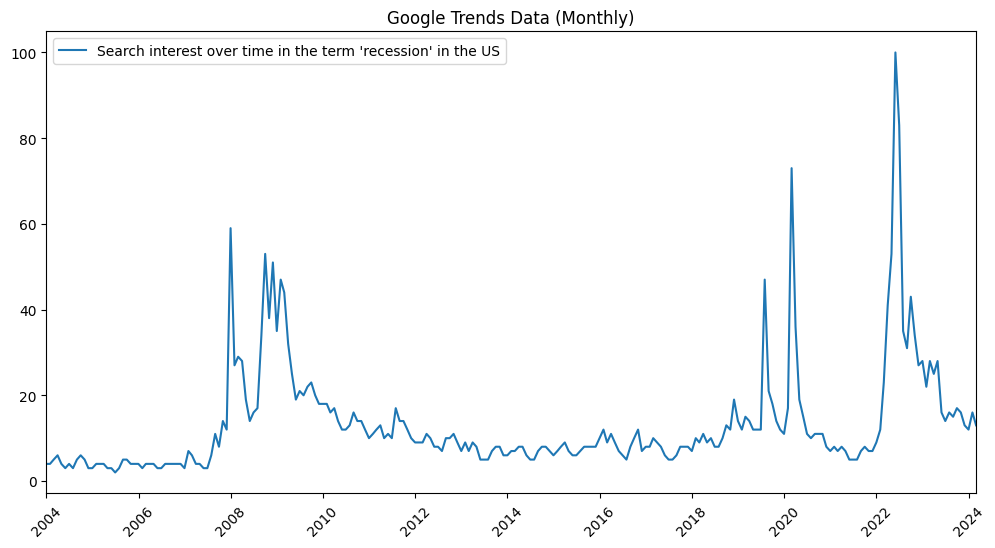

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(google_trends_data)
date_fmt = mdates.DateFormatter("%Y-%m")
plt.xlim(google_trends_data.index[0], google_trends_data.index[-1])
plt.xticks(rotation=45)
plt.title("Google Trends Data (Monthly)")
plt.legend(["Search interest over time in the term 'recession' in the US"])
plt.show()

But not every month-end is a trading day. Also, what value should the model train on for all the days in between month-ends? Below, we have provided you with code to convert the monthly data to daily and interpolate the end-of-month values to get all the in-between values. You will be using this new `google_trends_daily` data going forward.


In [16]:
google_trends_daily = google_trends_data.resample('D').asfreq().interpolate(method='linear')
google_trends_daily = google_trends_daily.rename_axis('Date')
google_trends_daily.index.freq = None
google_trends_daily

recession_search_trend
Date                              
2003-12-31                4.000000
2004-01-01                4.000000
2004-01-02                4.000000
2004-01-03                4.000000
2004-01-04                4.000000
...                            ...
2024-02-25               13.413793
2024-02-26               13.310345
2024-02-27               13.206897
2024-02-28               13.103448
2024-02-29               13.000000

[7366 rows x 1 columns]

## 2. Feature Engineering and Analysis


In this section, you will create a new DataFrame called `data` which will house all of the features as well as the prediction target. Then you will analyze the features and look for potentially problematic features.

Start by running the cell below to create `data` as an empty DataFrame with just an index that matches `XLV`'s.


In [17]:
data = pd.DataFrame(index=xlv_data.index)
data

Empty DataFrame
Columns: []
Index: [2004-01-02 00:00:00, 2004-01-05 00:00:00, 2004-01-06 00:00:00, 2004-01-07 00:00:00, 2004-01-08 00:00:00, 2004-01-09 00:00:00, 2004-01-12 00:00:00, 2004-01-13 00:00:00, 2004-01-14 00:00:00, 2004-01-15 00:00:00, 2004-01-16 00:00:00, 2004-01-20 00:00:00, 2004-01-21 00:00:00, 2004-01-22 00:00:00, 2004-01-23 00:00:00, 2004-01-26 00:00:00, 2004-01-27 00:00:00, 2004-01-28 00:00:00, 2004-01-29 00:00:00, 2004-01-30 00:00:00, 2004-02-02 00:00:00, 2004-02-03 00:00:00, 2004-02-04 00:00:00, 2004-02-05 00:00:00, 2004-02-06 00:00:00, 2004-02-09 00:00:00, 2004-02-10 00:00:00, 2004-02-11 00:00:00, 2004-02-12 00:00:00, 2004-02-13 00:00:00, 2004-02-17 00:00:00, 2004-02-18 00:00:00, 2004-02-19 00:00:00, 2004-02-20 00:00:00, 2004-02-23 00:00:00, 2004-02-24 00:00:00, 2004-02-25 00:00:00, 2004-02-26 00:00:00, 2004-02-27 00:00:00, 2004-03-01 00:00:00, 2004-03-02 00:00:00, 2004-03-03 00:00:00, 2004-03-04 00:00:00, 2004-03-05 00:00:00, 2004-03-08 00:00:00, 2004-03-09 00:00:00, 2004-03-10 00:00:00, 2004-03-11 00:00:00, 2004-03-12 00:00:00, 2004-03-15 00:00:00, 2004-03-16 00:00:00, 2004-03-17 00:00:00, 2004-03-18 00:00:00, 2004-03-19 00:00:00, 2004-03-22 00:00:00, 2004-03-23 00:00:00, 2004-03-24 00:00:00, 2004-03-25 00:00:00, 2004-03-26 00:00:00, 2004-03-29 00:00:00, 2004-03-30 00:00:00, 2004-03-31 00:00:00, 2004-04-01 00:00:00, 2004-04-02 00:00:00, 2004-04-05 00:00:00, 2004-04-06 00:00:00, 2004-04-07 00:00:00, 2004-04-08 00:00:00, 2004-04-12 00:00:00, 2004-04-13 00:00:00, 2004-04-14 00:00:00, 2004-04-15 00:00:00, 2004-04-16 00:00:00, 2004-04-19 00:00:00, 2004-04-20 00:00:00, 2004-04-21 00:00:00, 2004-04-22 00:00:00, 2004-04-23 00:00:00, 2004-04-26 00:00:00, 2004-04-27 00:00:00, 2004-04-28 00:00:00, 2004-04-29 00:00:00, 2004-04-30 00:00:00, 2004-05-03 00:00:00, 2004-05-04 00:00:00, 2004-05-05 00:00:00, 2004-05-06 00:00:00, 2004-05-07 00:00:00, 2004-05-10 00:00:00, 2004-05-11 00:00:00, 2004-05-12 00:00:00, 2004-05-13 00:00:00, 2004-05-14 00:00:00, 2004-05-17 00:00:00, 2004-05-18 00:00:00, 2004-05-19 00:00:00, 2004-05-20 00:00:00, 2004-05-21 00:00:00, 2004-05-24 00:00:00, 2004-05-25 00:00:00, ...]

[5094 rows x 0 columns]

### 2.1. Feature Engineering


#### 2.1.1. Month and Weekday


Add the `month` and `weekday` columns to `data` as categorical features (integer labels) from its index.


In [18]:
data['month'] = pd.DatetimeIndex(data.index).month
data['weekday'] = pd.DatetimeIndex(data.index).weekday
data

month  weekday
Date                      
2004-01-02      1        4
2004-01-05      1        0
2004-01-06      1        1
2004-01-07      1        2
2004-01-08      1        3
...           ...      ...
2024-03-22      3        4
2024-03-25      3        0
2024-03-26      3        1
2024-03-27      3        2
2024-03-28      3        3

[5094 rows x 2 columns]

You do not want to train a model using these columns as they are, because the numbers themselves and the inherent "order" of months and weekdays do not really have any significance, but the model may interpret them as meaningful. You could either (a) use one-hot encoding to turn each category to a separate binary feature, or (b) treat them as cyclical features. The choice is somewhat arbitrary and depends on how important a "feature" you believe the cyclicality to be.

Below, you will:

- Treat `month` as a cyclical feature, creating two features (`month_sin` and `month_cos`). (👉 See: [Trigonometric features](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#trigonometric-features))
- One-hot-encode `weekday` and create five additional features of type `int32` (one for each business day) with the `weekday` prefix. (👉 See: [`pandas.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html))
- Make sure the original `month` and `weekday` columns are no longer present in `data`. (`drop()` them if necessary.)


In [19]:
# Treat `month` as a "cyclical" feature with a period of 12 months.
data["month_sin"] = np.sin(2 * np.pi * data["month"] / 12)
data["month_cos"] = np.cos(2 * np.pi * data["month"] / 12)

# Drop the original `month` column.
data.drop(columns=["month"], inplace=True)

# Treat `weekday` as a "categorical" feature and one-hot-encode it.
data = pd.get_dummies(data, columns=["weekday"], prefix="weekday")
data

month_sin     month_cos  weekday_0  weekday_1  weekday_2  \
Date                                                                   
2004-01-02        0.5  8.660254e-01      False      False      False   
2004-01-05        0.5  8.660254e-01       True      False      False   
2004-01-06        0.5  8.660254e-01      False       True      False   
2004-01-07        0.5  8.660254e-01      False      False       True   
2004-01-08        0.5  8.660254e-01      False      False      False   
...               ...           ...        ...        ...        ...   
2024-03-22        1.0  6.123234e-17      False      False      False   
2024-03-25        1.0  6.123234e-17       True      False      False   
2024-03-26        1.0  6.123234e-17      False       True      False   
2024-03-27        1.0  6.123234e-17      False      False       True   
2024-03-28        1.0  6.123234e-17      False      False      False   

            weekday_3  weekday_4  
Date                              
2004-01-02      False       True  
2004-01-05      False      False  
2004-01-06      False      False  
2004-01-07      False      False  
2004-01-08       True      False  
...               ...        ...  
2024-03-22      False       True  
2024-03-25      False      False  
2024-03-26      False      False  
2024-03-27      False      False  
2024-03-28       True      False  

[5094 rows x 7 columns]

#### 2.1.2. Historical Returns


Next, add features for historical returns of the XLV ETF from its `Adj Close` column. For each date, calculate rolling **simple** returns over the past 1, 5, 10 and 20 days. Create 4 columns in `data` named `ret_#d_hist` where `#` is the lookback period. The list `hist_ret_lookbacks` is provided if you wish to use it.


In [20]:
# Create features for 1-day, 5-day, 10-day and 20-day historical returns
hist_ret_lookbacks = [1, 5, 10, 20]
for lookback in hist_ret_lookbacks:
    data[f'ret_{lookback}d_hist'] = xlv_data['Adj Close'].pct_change(lookback)
data

month_sin     month_cos  weekday_0  weekday_1  weekday_2  \
Date                                                                   
2004-01-02        0.5  8.660254e-01      False      False      False   
2004-01-05        0.5  8.660254e-01       True      False      False   
2004-01-06        0.5  8.660254e-01      False       True      False   
2004-01-07        0.5  8.660254e-01      False      False       True   
2004-01-08        0.5  8.660254e-01      False      False      False   
...               ...           ...        ...        ...        ...   
2024-03-22        1.0  6.123234e-17      False      False      False   
2024-03-25        1.0  6.123234e-17       True      False      False   
2024-03-26        1.0  6.123234e-17      False       True      False   
2024-03-27        1.0  6.123234e-17      False      False       True   
2024-03-28        1.0  6.123234e-17      False      False      False   

            weekday_3  weekday_4  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02      False       True          NaN          NaN           NaN   
2004-01-05      False      False     0.004632          NaN           NaN   
2004-01-06      False      False     0.002965          NaN           NaN   
2004-01-07      False      False     0.006239          NaN           NaN   
2004-01-08       True      False    -0.004242          NaN           NaN   
...               ...        ...          ...          ...           ...   
2024-03-22      False       True    -0.001373     0.004163     -0.003174   
2024-03-25      False      False    -0.001375     0.002900     -0.004001   
2024-03-26      False      False     0.003649    -0.000069     -0.004990   
2024-03-27      False      False     0.013309     0.015538      0.012177   
2024-03-28       True      False     0.000135     0.014350      0.015921   

            ret_20d_hist  
Date                      
2004-01-02           NaN  
2004-01-05           NaN  
2004-01-06           NaN  
2004-01-07           NaN  
2004-01-08           NaN  
...                  ...  
2024-03-22     -0.012815  
2024-03-25     -0.009079  
2024-03-26     -0.003023  
2024-03-27      0.015296  
2024-03-28      0.023777  

[5094 rows x 11 columns]

The cell below plots the histograms of the returns you just calculated. They should look normally distributed around zero.


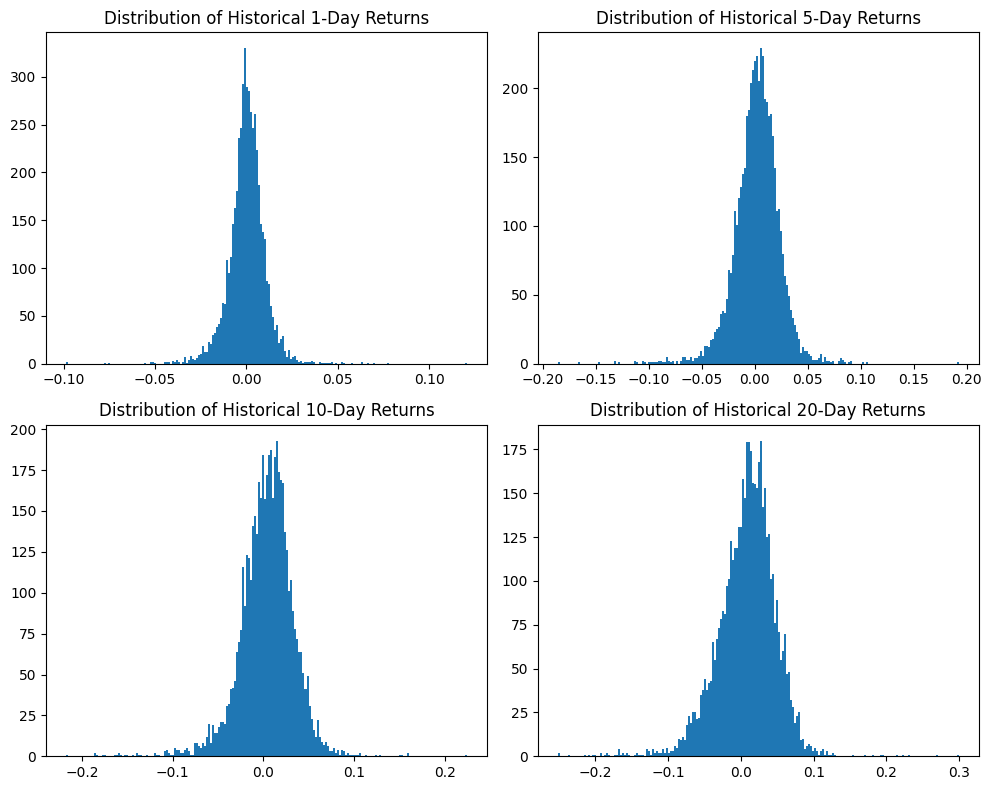

In [21]:
hist_ret_lookbacks = [1, 5, 10, 20] # In case it was deleted from the previous cell

fig, axs = plt.subplots(2, 2, figsize=(10, 8))


def plot_hist_returns(ax, data, col, title):
    ax.hist(data[col], bins=200)
    ax.set_title(title)


for i, n_days in enumerate(hist_ret_lookbacks):
    plot_hist_returns(
        axs[i // 2, i % 2], data, f"ret_{n_days}d_hist", f"Distribution of Historical {n_days}-Day Returns"
    )

plt.tight_layout()
plt.show()

#### 2.1.3. Trade Volumes

As trading volumes span several orders of magnitude, take the natural logarithm of `Volume` and use it as a feature instead. This helps emphasize variations in its lower range. Use `np.log()` and call this new feature `log_volume`.

**Note:** For tree-based models such as Decision Trees and Random Forests, scaling is not necessary. But feature scaling becomes critically important if you use other model types (e.g. distance-based models).


In [22]:
data["log_volume"] = np.log(xlv_data["Volume"])

#### 2.1.4. Technical Indicators

Add a feature named `ibs` which is calculated as (Close - Low) / (High - Low). This measure, a number between zero and one and sometimes referred to as the "Internal Bar Strength", denotes how "strong" the closing price is relative to the high and low prices within the same period.
> **Note:** Make sure to use `Close` (not `Adj Close`).

In [23]:
# Engineer the technical indicator "Internal Bar Strength" (IBS) from XLV's price data
data["ibs"] = (xlv_data["Close"] - xlv_data["Low"]) / (xlv_data["High"] - xlv_data["Low"])

Run the cell below to add a few more technical indicators, including Bollinger Band features and indicators, as well as the Relative Strength Index (RSI).

In [24]:
# Get some more technical indicators using the `ta` library

indicator_bb = BollingerBands(close=xlv_data["Close"], window=20, window_dev=2)
indicator_rsi = RSIIndicator(close=xlv_data["Close"], window=14)

# Add Bollinger Bands features
data["bb_bbm"] = indicator_bb.bollinger_mavg()
data["bb_bbh"] = indicator_bb.bollinger_hband()
data["bb_bbl"] = indicator_bb.bollinger_lband()

# Add Bollinger Band high and low indicators
data["bb_bbhi"] = indicator_bb.bollinger_hband_indicator()
data["bb_bbli"] = indicator_bb.bollinger_lband_indicator()

# Add Width Size and Percentage Bollinger Bands
data["bb_bbw"] = indicator_bb.bollinger_wband()
data["bb_bbp"] = indicator_bb.bollinger_pband()

# Add RSI
data["rsi"] = indicator_rsi.rsi()

#### 2.1.5. The Target of Prediction

Add the column `tgt_is_pos_ret_5d_fut` as type `int` to `data`, denoting whether forward-looking 5-day returns on each day are positive (a value of `1`) or negative (a value of `0`).
> **Note:** Again, as before, calculte **simple** returns from the `Adj Close` column of `xlv_data`.

In [25]:
# Create the prediction target: an integer indicating whether future 5-day returns are positive (1) or negative (0)
data["tgt_is_pos_ret_5d_fut"] = (xlv_data["Adj Close"].shift(-5) > xlv_data["Adj Close"]).astype(int)  
data

month_sin     month_cos  weekday_0  weekday_1  weekday_2  \
Date                                                                   
2004-01-02        0.5  8.660254e-01      False      False      False   
2004-01-05        0.5  8.660254e-01       True      False      False   
2004-01-06        0.5  8.660254e-01      False       True      False   
2004-01-07        0.5  8.660254e-01      False      False       True   
2004-01-08        0.5  8.660254e-01      False      False      False   
...               ...           ...        ...        ...        ...   
2024-03-22        1.0  6.123234e-17      False      False      False   
2024-03-25        1.0  6.123234e-17       True      False      False   
2024-03-26        1.0  6.123234e-17      False       True      False   
2024-03-27        1.0  6.123234e-17      False      False       True   
2024-03-28        1.0  6.123234e-17      False      False      False   

            weekday_3  weekday_4  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02      False       True          NaN          NaN           NaN   
2004-01-05      False      False     0.004632          NaN           NaN   
2004-01-06      False      False     0.002965          NaN           NaN   
2004-01-07      False      False     0.006239          NaN           NaN   
2004-01-08       True      False    -0.004242          NaN           NaN   
...               ...        ...          ...          ...           ...   
2024-03-22      False       True    -0.001373     0.004163     -0.003174   
2024-03-25      False      False    -0.001375     0.002900     -0.004001   
2024-03-26      False      False     0.003649    -0.000069     -0.004990   
2024-03-27      False      False     0.013309     0.015538      0.012177   
2024-03-28       True      False     0.000135     0.014350      0.015921   

            ret_20d_hist  log_volume       ibs      bb_bbm      bb_bbh  \
Date                                                                     
2004-01-02           NaN   13.351409  0.312496         NaN         NaN   
2004-01-05           NaN   12.162643  0.611113         NaN         NaN   
2004-01-06           NaN   12.575219  0.823537         NaN         NaN   
2004-01-07           NaN   12.477244  1.000000         NaN         NaN   
2004-01-08           NaN   12.275132  0.500000         NaN         NaN   
...                  ...         ...       ...         ...         ...   
2024-03-22     -0.012815   15.527000  0.187507  145.979001  147.311830   
2024-03-25     -0.009079   15.474310  0.270599  145.886001  147.150805   
2024-03-26     -0.003023   15.753158  0.787503  145.837501  147.040475   
2024-03-27      0.015296   15.989967  1.000000  145.922501  147.376307   
2024-03-28      0.023777   15.906164  0.090914  146.068001  147.629788   

                bb_bbl  bb_bbhi  bb_bbli    bb_bbw    bb_bbp        rsi  \
Date                                                                      
2004-01-02         NaN      0.0      0.0       NaN       NaN        NaN   
2004-01-05         NaN      0.0      0.0       NaN       NaN        NaN   
2004-01-06         NaN      0.0      0.0       NaN       NaN        NaN   
2004-01-07         NaN      0.0      0.0       NaN       NaN        NaN   
2004-01-08         NaN      0.0      0.0       NaN       NaN        NaN   
...                ...      ...      ...       ...       ...        ...   
2024-03-22  144.646172      0.0      0.0  1.826056  0.297799  51.608138   
2024-03-25  144.621197      0.0      0.0  1.733962  0.244626  50.296176   
2024-03-26  144.634527      0.0      0.0  1.649746  0.471946  53.658283   
2024-03-27  144.468696      1.0      0.0  1.992572  1.114768  63.413817   
2024-03-28  144.506214      1.0      0.0  2.138438  1.032081  63.499079   

            tgt_is_pos_ret_5d_fut  
Date                               
2004-01-02                      1  
2004-01-05                      0  
200

Run the cells below to get an idea of how balanced the distribution of the target variable is throughout the data.

In [26]:
target_col_name = "tgt_is_pos_ret_5d_fut"
# Inspect the distribution of the target variable
target_value_counts = data[target_col_name].value_counts()
target_value_counts / len(data)


tgt_is_pos_ret_5d_fut
1    0.566156
0    0.433844
Name: count, dtype: float64

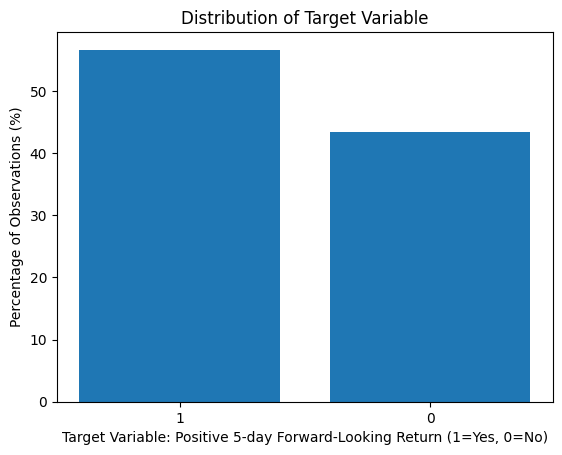

In [27]:
target_value_percentages = target_value_counts / len(data) * 100

plt.bar(target_value_percentages.index.astype(str), target_value_percentages.values)
plt.xlabel("Target Variable: Positive 5-day Forward-Looking Return (1=Yes, 0=No)")
plt.ylabel("Percentage of Observations (%)")
plt.title("Distribution of Target Variable")
plt.show()

Does the data look relatively balanced or grossly unbalanced in the distribution of the target variable? Why is this important?


In [28]:
answer = "Data is balanced (roughly 55% positive and 45% negative). The benchmark could be having an ML model with accuracy higher than 55% (which would be the simple strategy of always going long)"

#### 2.1.6. Stitching Everything Together

You will now add the `vix_data` and `google_trends_daily` as features to `data`. You will also rename the column corresponding to the VIX feature. Run the cell below to do so.

In [29]:
google_trends_daily.index

DatetimeIndex(['2003-12-31', '2004-01-01', '2004-01-02', '2004-01-03',
               '2004-01-04', '2004-01-05', '2004-01-06', '2004-01-07',
               '2004-01-08', '2004-01-09',
               ...
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-24', '2024-02-25', '2024-02-26', '2024-02-27',
               '2024-02-28', '2024-02-29'],
              dtype='datetime64[ns]', name='Date', length=7366, freq=None)

In [30]:
data.index

DatetimeIndex(['2004-01-02', '2004-01-05', '2004-01-06', '2004-01-07',
               '2004-01-08', '2004-01-09', '2004-01-12', '2004-01-13',
               '2004-01-14', '2004-01-15',
               ...
               '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26',
               '2024-03-27', '2024-03-28'],
              dtype='datetime64[ns]', name='Date', length=5094, freq=None)

In [31]:
vix_data.index

DatetimeIndex(['2004-01-02', '2004-01-05', '2004-01-06', '2004-01-07',
               '2004-01-08', '2004-01-09', '2004-01-12', '2004-01-13',
               '2004-01-14', '2004-01-15',
               ...
               '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26',
               '2024-03-27', '2024-03-28'],
              dtype='datetime64[ns]', name='Date', length=5094, freq=None)

In [32]:
# Join with the Google Trends data and VIX data
data = data.join(google_trends_daily, how="left")
data = data.join(vix_data["Adj Close"], how="left")
data.rename(columns={"Adj Close": "vix"}, inplace=True)

In [33]:
data

month_sin     month_cos  weekday_0  weekday_1  weekday_2  \
Date                                                                   
2004-01-02        0.5  8.660254e-01      False      False      False   
2004-01-05        0.5  8.660254e-01       True      False      False   
2004-01-06        0.5  8.660254e-01      False       True      False   
2004-01-07        0.5  8.660254e-01      False      False       True   
2004-01-08        0.5  8.660254e-01      False      False      False   
...               ...           ...        ...        ...        ...   
2024-03-22        1.0  6.123234e-17      False      False      False   
2024-03-25        1.0  6.123234e-17       True      False      False   
2024-03-26        1.0  6.123234e-17      False       True      False   
2024-03-27        1.0  6.123234e-17      False      False       True   
2024-03-28        1.0  6.123234e-17      False      False      False   

            weekday_3  weekday_4  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02      False       True          NaN          NaN           NaN   
2004-01-05      False      False     0.004632          NaN           NaN   
2004-01-06      False      False     0.002965          NaN           NaN   
2004-01-07      False      False     0.006239          NaN           NaN   
2004-01-08       True      False    -0.004242          NaN           NaN   
...               ...        ...          ...          ...           ...   
2024-03-22      False       True    -0.001373     0.004163     -0.003174   
2024-03-25      False      False    -0.001375     0.002900     -0.004001   
2024-03-26      False      False     0.003649    -0.000069     -0.004990   
2024-03-27      False      False     0.013309     0.015538      0.012177   
2024-03-28       True      False     0.000135     0.014350      0.015921   

            ret_20d_hist  log_volume       ibs      bb_bbm      bb_bbh  \
Date                                                                     
2004-01-02           NaN   13.351409  0.312496         NaN         NaN   
2004-01-05           NaN   12.162643  0.611113         NaN         NaN   
2004-01-06           NaN   12.575219  0.823537         NaN         NaN   
2004-01-07           NaN   12.477244  1.000000         NaN         NaN   
2004-01-08           NaN   12.275132  0.500000         NaN         NaN   
...                  ...         ...       ...         ...         ...   
2024-03-22     -0.012815   15.527000  0.187507  145.979001  147.311830   
2024-03-25     -0.009079   15.474310  0.270599  145.886001  147.150805   
2024-03-26     -0.003023   15.753158  0.787503  145.837501  147.040475   
2024-03-27      0.015296   15.989967  1.000000  145.922501  147.376307   
2024-03-28      0.023777   15.906164  0.090914  146.068001  147.629788   

                bb_bbl  bb_bbhi  bb_bbli    bb_bbw    bb_bbp        rsi  \
Date                                                                      
2004-01-02         NaN      0.0      0.0       NaN       NaN        NaN   
2004-01-05         NaN      0.0      0.0       NaN       NaN        NaN   
2004-01-06         NaN      0.0      0.0       NaN       NaN        NaN   
2004-01-07         NaN      0.0      0.0       NaN       NaN        NaN   
2004-01-08         NaN      0.0      0.0       NaN       NaN        NaN   
...                ...      ...      ...       ...       ...        ...   
2024-03-22  144.646172      0.0      0.0  1.826056  0.297799  51.608138   
2024-03-25  144.621197      0.0      0.0  1.733962  0.244626  50.296176   
2024-03-26  144.634527      0.0      0.0  1.649746  0.471946  53.658283   
2024-03-27  144.468696      1.0      0.0  1.992572  1.114768  63.413817   
2024-03-28  144.506214      1.0      0.0  2.138438  1.032081  63.499079   

            tgt_is_pos_ret_5d_fut  recession_search_trend        vix  
Date                                                                  
2004-

### 2.2. Further Data Preprocessing and Cleaning


While engineering new features, some `NaN` values were created. You now need to clean the combined DataFrame. Inspect `data` to see how many `NaN` values there are per column.

In [34]:
data.isna().sum()

month_sin                  0
month_cos                  0
weekday_0                  0
weekday_1                  0
weekday_2                  0
weekday_3                  0
weekday_4                  0
ret_1d_hist                1
ret_5d_hist                5
ret_10d_hist              10
ret_20d_hist              20
log_volume                 0
ibs                        0
bb_bbm                    19
bb_bbh                    19
bb_bbl                    19
bb_bbhi                    0
bb_bbli                    0
bb_bbw                    19
bb_bbp                    19
rsi                       13
tgt_is_pos_ret_5d_fut      0
recession_search_trend    20
vix                        0
dtype: int64

Some features, such as historical returns, RSI, Bollinger Bands and BB indicators cannot be calculated for the first `n` days due to their "rolling" nature. In general, missing values can sometimes be imputed with reasonable estimates. But here you will simply drop the rows containing them. The largest `n` is `20`, corresponding to the calculation of 20-day historical returns. Drop the first 20 rows of `data`.


In [35]:
data_after_20 = data.iloc[20:]

Are there any more missing values?

In [36]:
data_after_20.isna().sum()

month_sin                  0
month_cos                  0
weekday_0                  0
weekday_1                  0
weekday_2                  0
weekday_3                  0
weekday_4                  0
ret_1d_hist                0
ret_5d_hist                0
ret_10d_hist               0
ret_20d_hist               0
log_volume                 0
ibs                        0
bb_bbm                     0
bb_bbh                     0
bb_bbl                     0
bb_bbhi                    0
bb_bbli                    0
bb_bbw                     0
bb_bbp                     0
rsi                        0
tgt_is_pos_ret_5d_fut      0
recession_search_trend    20
vix                        0
dtype: int64

Even if there aren't, you remember that when you calculated the target variable (`tgt_is_pos_ret_5d_fut`) based on forward-looking 5-day rolling returns, you could not have known future returns for the last five days of `data`! Therefore the last 5 rows of data should be dropped.


In [37]:
data.dropna(inplace=True)

Let us take a final look at the types and statistical characteristics of the set of features and targets.


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5054 entries, 2004-02-02 to 2024-02-29
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month_sin               5054 non-null   float64
 1   month_cos               5054 non-null   float64
 2   weekday_0               5054 non-null   bool   
 3   weekday_1               5054 non-null   bool   
 4   weekday_2               5054 non-null   bool   
 5   weekday_3               5054 non-null   bool   
 6   weekday_4               5054 non-null   bool   
 7   ret_1d_hist             5054 non-null   float64
 8   ret_5d_hist             5054 non-null   float64
 9   ret_10d_hist            5054 non-null   float64
 10  ret_20d_hist            5054 non-null   float64
 11  log_volume              5054 non-null   float64
 12  ibs                     5054 non-null   float64
 13  bb_bbm                  5054 non-null   float64
 14  bb_bbh                

In [39]:
data.describe()

month_sin     month_cos  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
count  5.054000e+03  5.054000e+03  5054.000000  5054.000000   5054.000000   
mean  -5.815142e-03 -7.594516e-03     0.000426     0.002107      0.004197   
std    7.086555e-01  7.056301e-01     0.010505     0.021756      0.029855   
min   -1.000000e+00 -1.000000e+00    -0.098610    -0.185835     -0.217250   
25%   -8.660254e-01 -8.660254e-01    -0.004478    -0.009228     -0.011693   
50%   -2.449294e-16 -1.836970e-16     0.000636     0.002969      0.005988   
75%    5.000000e-01  5.000000e-01     0.005896     0.014895      0.021993   
max    1.000000e+00  1.000000e+00     0.120547     0.192308      0.223935   

       ret_20d_hist   log_volume          ibs       bb_bbm       bb_bbh  \
count   5054.000000  5054.000000  5054.000000  5054.000000  5054.000000   
mean       0.008331    15.407773     0.534039    64.951316    66.908118   
std        0.040541     1.083167     0.308103    36.279490    37.441214   
min       -0.251548    10.980195     0.000000    23.217500    24.569328   
25%       -0.013539    15.155401     0.258897    32.027750    32.773829   
50%        0.011500    15.701352     0.546169    56.409250    58.379837   
75%        0.032989    16.074966     0.818179    90.317000    93.023174   
max        0.299116    18.012264     1.000000   144.764999   148.369194   

            bb_bbl      bb_bbhi      bb_bbli       bb_bbw       bb_bbp  \
count  5054.000000  5054.000000  5054.000000  5054.000000  5054.000000   
mean     62.994514     0.060942     0.054214     5.957068     0.567380   
std      35.162387     0.239247     0.226463     3.645914     0.326764   
min      20.419952     0.000000     0.000000     1.165471    -0.452267   
25%      31.146033     0.000000     0.000000     3.794745     0.310016   
50%      54.605284     0.000000     0.000000     5.057951     0.623209   
75%      87.077641     0.000000     0.000000     7.024024     0.833061   
max     141.491360     1.000000     1.000000    32.354816     1.349959   

               rsi  tgt_is_pos_ret_5d_fut  recession_search_trend          vix  
count  5054.000000            5054.000000             5054.000000  5054.000000  
mean     53.674298               0.565888               13.317155    19.114840  
std      11.266673               0.495689               12.439397     8.756313  
min      13.539141               0.000000                2.000000     9.140000  
25%      46.001993               0.000000                6.404839    13.380000  
50%      54.051972               1.000000                9.266667    16.585000  
75%      61.832737               1.000000               14.925806    22.137499  
max      85.413254               1.000000              100.000000    82.690002

### 2.3. Correlation Analysis


Correlation analysis can be a rough and early form of feature importance analysis. Features that are highly correlated (in either direction) with each other but not with the target variable, are a sign of multicollinearity problems, which means they may not contribute much additional information in predicting the target. In fact, depending on the algorithm used, multicollinearity may result in stability and reliability issues. Checking the correlation matrix can be helpful in identifying such features.  

Plot the heatmap of the correlation matrix of features/target and identify a cluster of 3 features that are almost certainly collinear. (Hint: `bb_bbm` is one of them.) You can pass the correlation matrix directly to [Seaborn's `heatmap()` method](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

<Axes: >

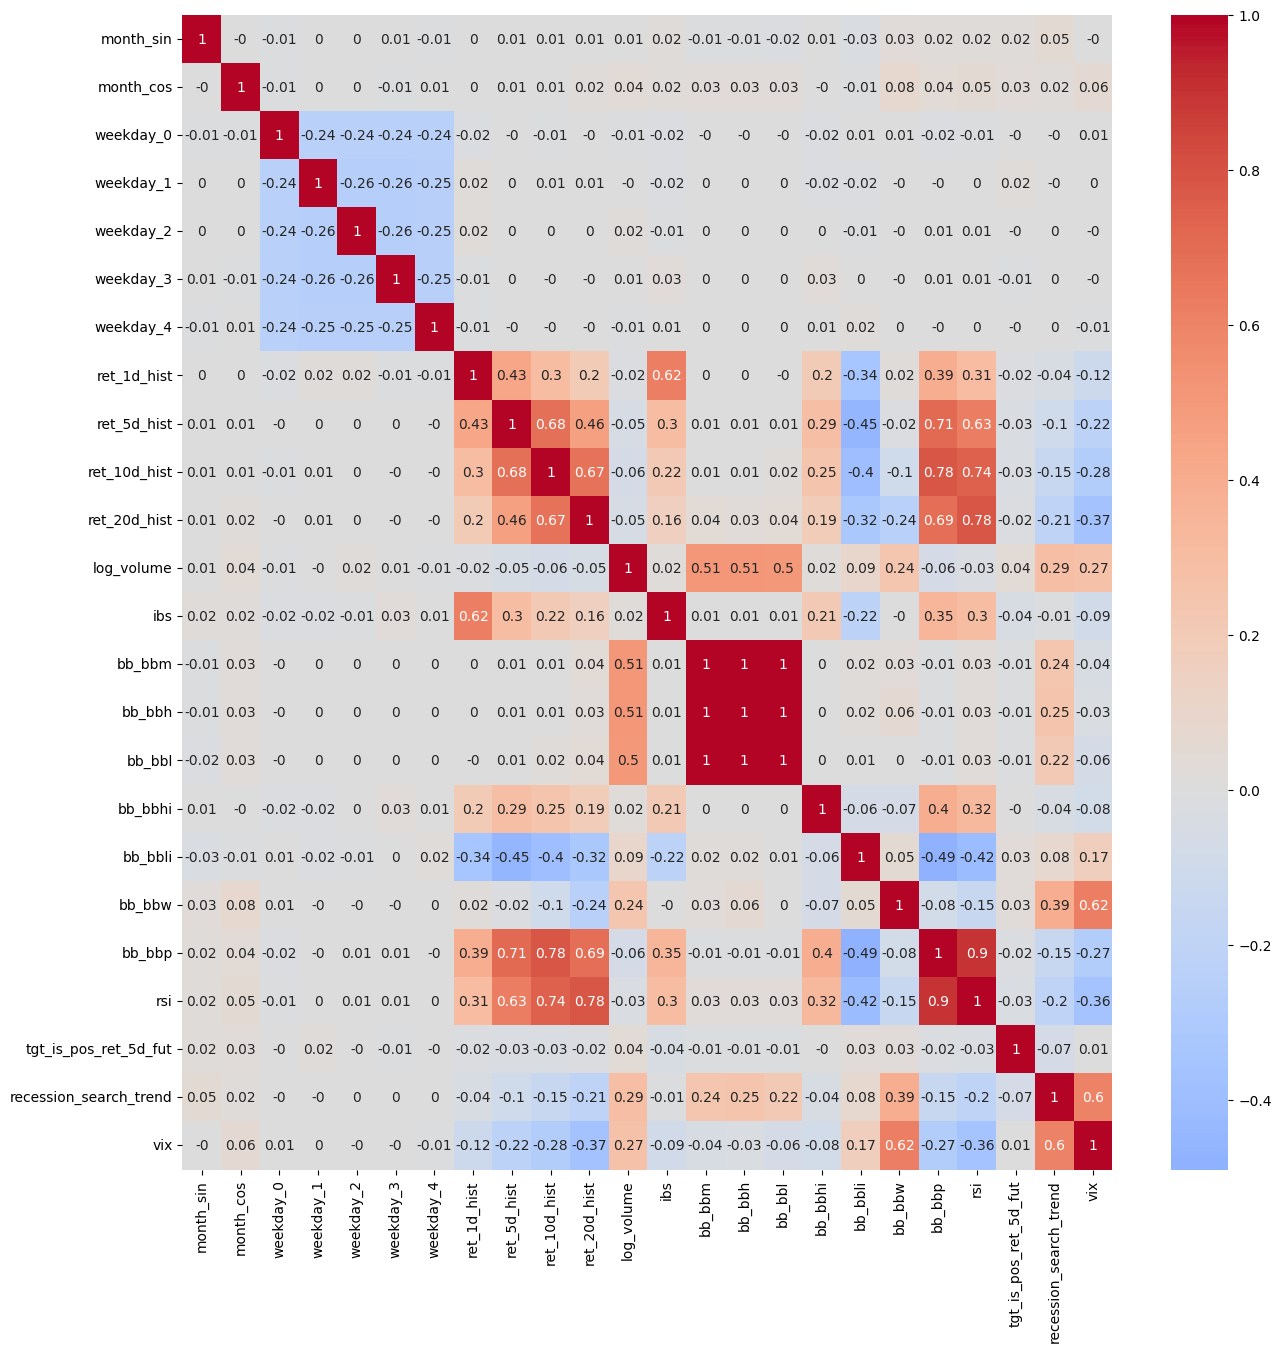

In [40]:
plt.figure(figsize=(15, 15))
# Round for better display
correlation_matrix = data.corr().round(2)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)

In such scenarios, we usually eliminate all but one of the collinear features. Keep `bb_bbm` and drop the other two features that are highly linearly related to it.

In [41]:
data.drop(columns=["bb_bbh", "bb_bbl"], inplace=True)

There is also one feature that is very highly correlated with `rsi` (which makes intuitive sense, as it, too, is a measure of relative strength). Find it an eliminate it, leaving `rsi` intact.

In [42]:
data.drop(columns=["bb_bbp"], inplace=True)

Plot the heatmap of the new, reduced correlation matrix.

<Axes: >

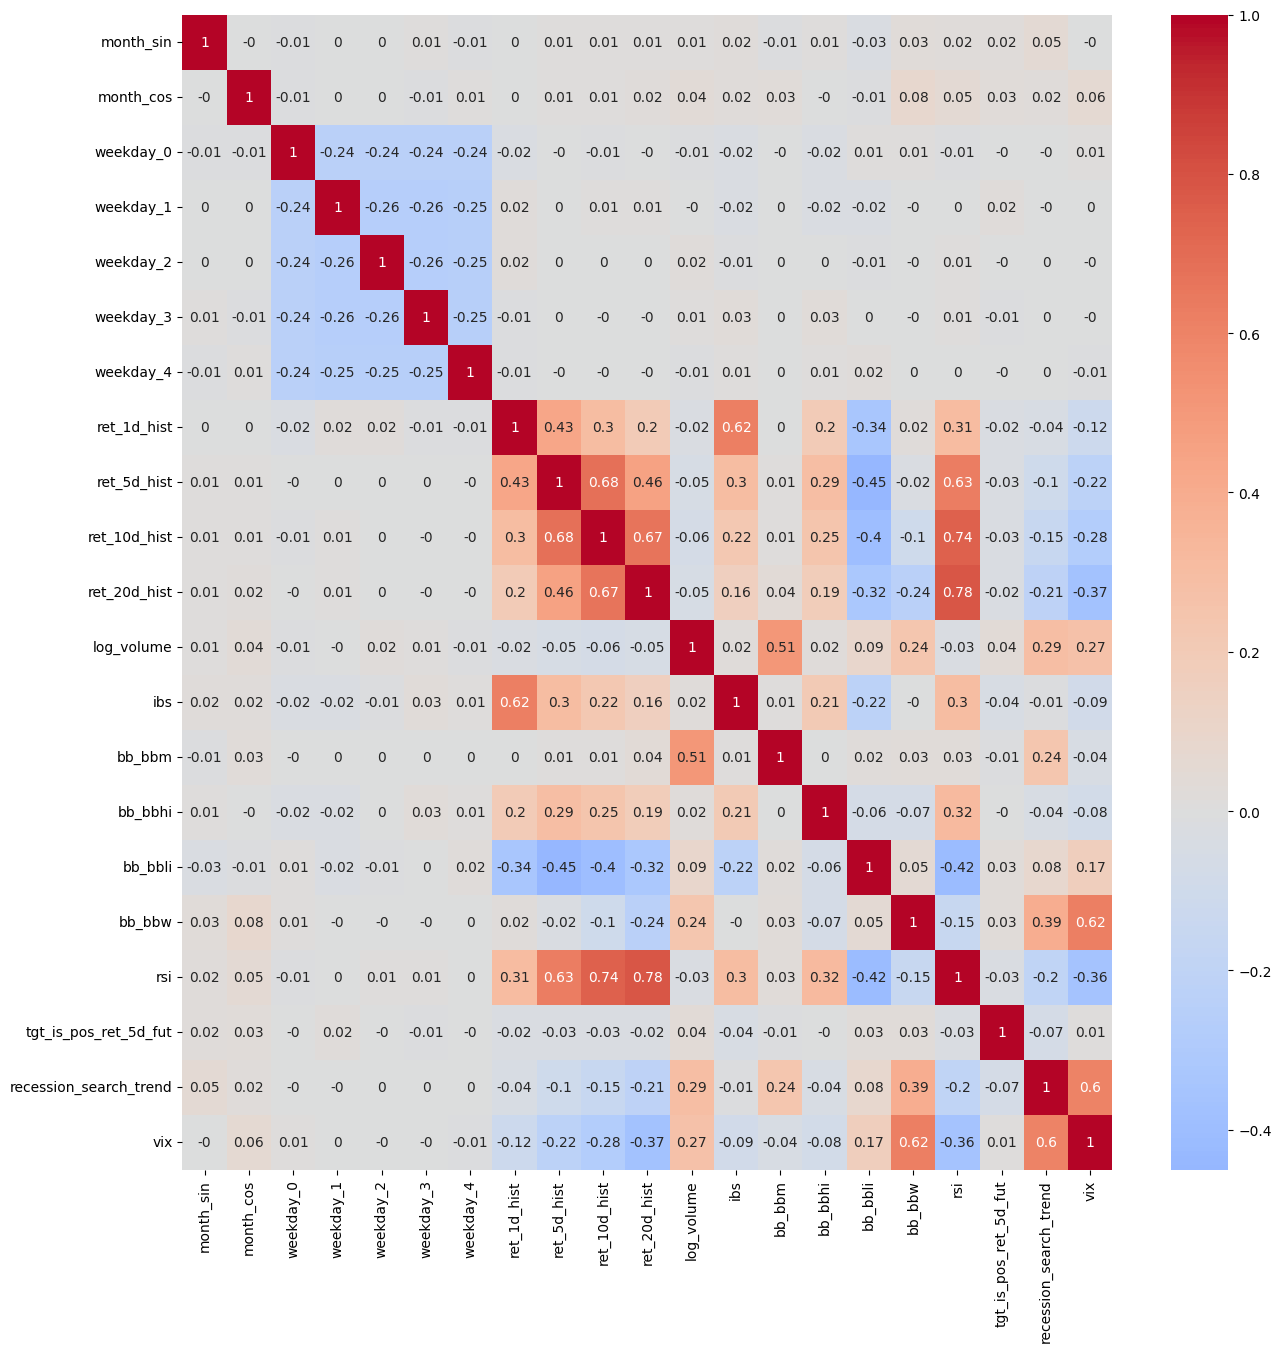

In [43]:
plt.figure(figsize=(15, 15))
# Round for better display
correlation_matrix = data.corr().round(2)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)

Features that are highly correlated (negatively or positively) **with the target variable** are likely more important. Which two (2) independent variables (features) are correlated more than 4% (**in either direction**) with the boolean target variable denoting whether 5-day future returns are positive?


In [44]:
correlation_matrix = data.corr()
target_correlations = correlation_matrix["tgt_is_pos_ret_5d_fut"].drop("tgt_is_pos_ret_5d_fut")
important_features = target_correlations[abs(target_correlations) > 0.04].index.tolist()
answer = f"The two features that are correlated more than 4% with the target variable are: {important_features}"
answer

"The two features that are correlated more than 4% with the target variable are: ['log_volume', 'ibs', 'recession_search_trend']"

## 3. The Training-Validation-Testing Split


In this section, you will split the `data` set into two sets: the training and validation set, and the testing set. You will then come up with a baseline score so that you have a reference point for evaluating your model's performance.

**Note:** Technically, since you are not going to use classical statistics-based time-series prediction methods (such as ARIMA), you can shuffle the data before splitting it. But for ease of interpretability and backtesting, you may as well keep the data in its original order. This is fine as long as the distributions of features and the target variable do not significantly shift over time. - And that is an important assumption related to drift analysis, which was covered in the course, but we will not get to in this project.

### 3.1. The Split


It is time to split the data, temporally, into the training + validation and testing sets. You will train and optimize (i.e. cross-validate) your model on the first 80% of the data, and use the remaining 20% for the test set (i.e. to evaluate the performance of your model). Use the `train_test_split()` method from scikit-learn's `model_selection` module to perform the split.
> **Note:** Please make sure to set `shuffle=False` and `random_state=RANDOM_STATE`.

In [45]:
X = data.drop(columns=["tgt_is_pos_ret_5d_fut"])
y = data["tgt_is_pos_ret_5d_fut"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=RANDOM_SEED)

### 3.2. Baseline Model and Score


Earlier, you inspected the distribution of the target variable across the entire data set. Run the cell below to analyze at the distribution of the target variable in each split.

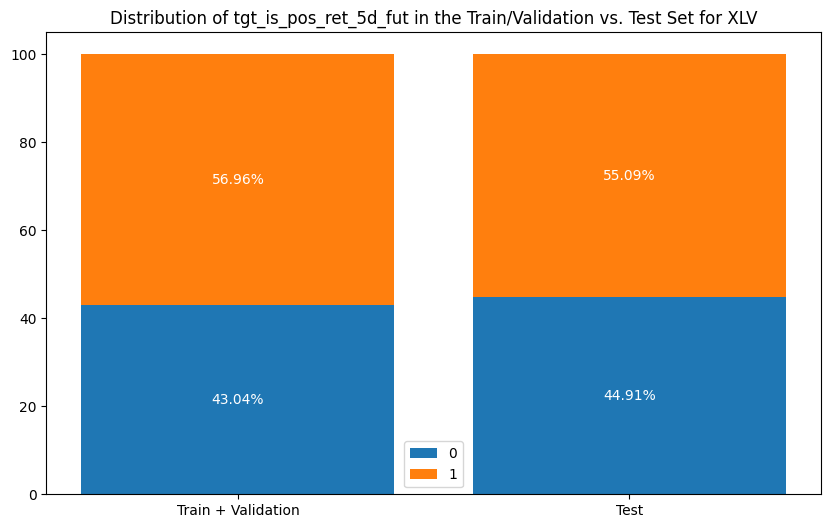

In [46]:
train_val_pct = y_train_val.value_counts(normalize=True) * 100
test_pct = y_test.value_counts(normalize=True) * 100

categories = ["Train + Validation", "Test"]
zero_counts = [train_val_pct[0], test_pct[0]]
one_counts = [train_val_pct[1], test_pct[1]]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(categories, zero_counts, label="0")
ax.bar(categories, one_counts, bottom=zero_counts, label="1")

# Add text annotations
for i, (zero, one) in enumerate(zip(zero_counts, one_counts)):
    ax.text(i, zero / 2, f"{zero:.2f}%", ha="center", va="center", color="white")
    ax.text(
        i,
        zero + one / 2,
        f"{one:.2f}%",
        ha="center",
        va="center",
        color="white",
    )
ax.set_title(f"Distribution of {target_col_name} in the Train/Validation vs. Test Set for XLV")
ax.legend()

plt.show()

If you were to devise a simple model that naively always predicted the majority class, what would the accuracy score of your model be on the training+validation set? How about on the testing set? Consider the latter your baseline score, i.e. a reference score to compare your more sophisticated model's performace to.

In [47]:
baseline_accuracy_train_val_score = train_val_pct[1]
print(f"Baseline accuracy for train + validation set {baseline_accuracy_train_val_score}")
baseline_accuracy_test_score = test_pct[1]
print(f"Baseline accuracy for test set {baseline_accuracy_test_score}")

Baseline accuracy for train + validation set 56.96265149641355
Baseline accuracy for test set 55.093966369930754


## 4. Model Training and Tuning


In this section, you will train a `RandomForestClassifier`, a robust, versatile ensemble learning method that uses "bagging" (also known as "bootstrap aggregating") to train multiple Decision Trees. The technical details of the model are beyond the scope of this course, but you may read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Run the cell below which defines a function that allows you to plot learning curves annotated with a hyperparameter named `max_depth` which you pass to it.

In [48]:
def plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axs.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="b",
    )
    axs.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",
    )
    axs.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="b",
        label="Average Score on Training Sets",
    )
    axs.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="r",
        label="Average Score on Test Sets",
    )
    axs.set_xlabel("Training examples")
    axs.set_ylabel("Score")
    axs.set_title(f"Learning Curves (max_depth={max_depth})")
    axs.legend(loc="center left")
    axs.grid(True)

Below is the first iteration of your model. It uses the default values for most of its hyperparameters. We have only specified one hyperparameter, `max_depth=10`.

In [49]:
max_depth = 10
model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)

Use the `learning_curve()` method from scikit-learn's `model_selection` module to cross-validate your model, with `accuracy` as the `scoring` metric. Use 10%, 20%, 30%,... , and 100% of the training+validatin data, with 5-fold cross-validation.

In [50]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_val, y_train_val, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

Inspect the learning curves.

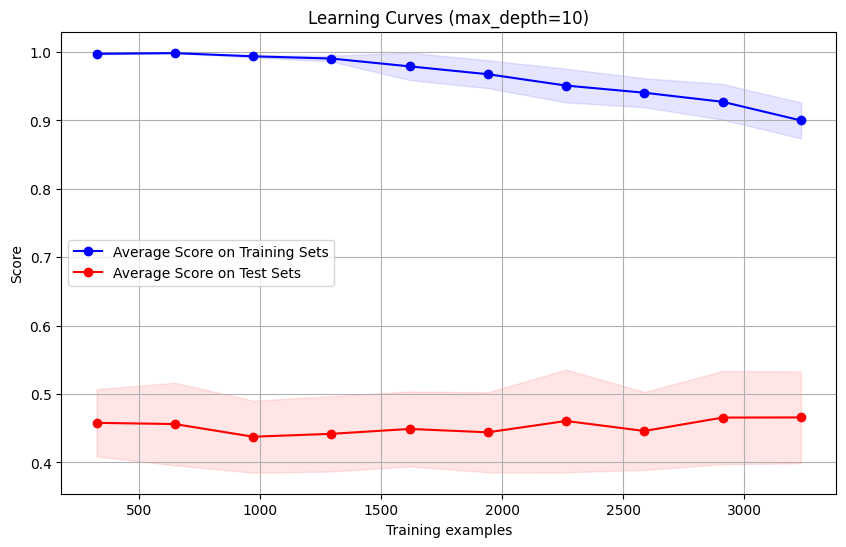

In [51]:
figure = plt.figure(figsize=(10, 6))
axs = figure.gca()

plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs)

plt.show()

Wondering what effect different values of the `max_depth` hyperparameter have, you decide to experiment with lower (`10`) and higher (`20`) values of it to see how the plots change. Run the cell below to help you answer the questions that follow it.


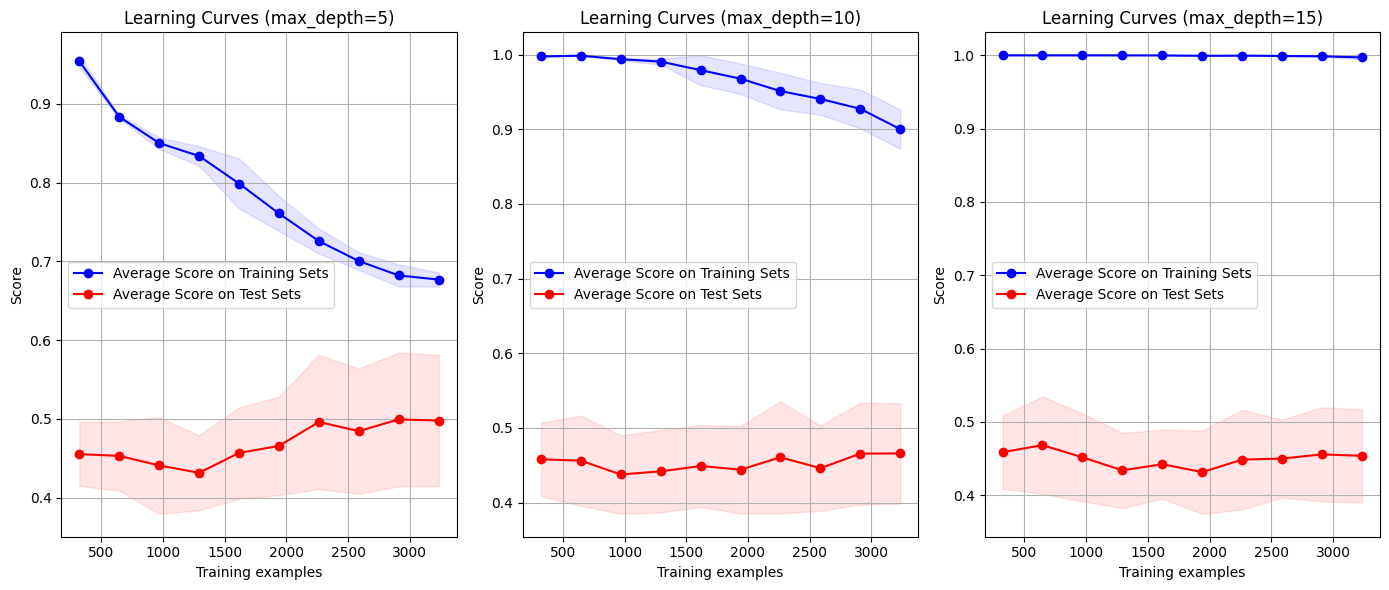

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
max_depth_range = [5, 10, 15]
for i, max_depth in enumerate(max_depth_range):
    model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
    )
    plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs[i])

plt.tight_layout()
plt.show()

With a value of `max_depth=15`, does your model overfit or underfit?


In [53]:
answer = "It overfits the training data because the training score is much higher than the validation score. The model is too complex for the data."

With a value of `max_depth=15`, is your performance metric (accuracy score) more likely to improve with more training data or with higher model complexity?

In [54]:
answer = "With a value of 15, the performance metric is more likely to increase with more data, rather than with model complexity. This will prevent overfitting the data if more data is available."

Random Forest Classifiers have several other hyperparameters, such as `min_samples_split` (default=2), `min_samples_leaf` (default=1) and `n_estimators` (default=100). So far, you have been tuning your model manually. But with all the possible combinations of hyperparameters, this is not tractable.  

Use grid search cross-validation (the `GridSearchCV` class from scikit-learn's `model_selection` module) to find the optimal combination of hyperparameters from the search space specified below:
- `max_depth` = 2, 3, 4 or 5
- `min_samples_leaf` = 1, 2, 3 or 4
- `n_estimators` = 50, 75, 100, 125, or 150

As before, use 5-fold cross-validation and accuracy as the `scoring` metric. Name your tuning model `search`.

> Note: Setting `n_jobs=-1` will allow Python to take advantage of parallel computing on your computer to speed up the training.

In [55]:
grid = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4],
    "n_estimators": [50, 75, 100, 125, 150]
}

model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)

search.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [50, 75, 100, 125, 150]},
             scoring='accuracy')

Run the cell below to see the top 5 best performing hyperparameter combinations.

In [56]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
16       0.109384      0.022478         0.038513        0.011751   
11       0.119879      0.016057         0.055732        0.028748   
1        0.100691      0.004396         0.026872        0.006119   
6        0.105421      0.018348         0.040225        0.022301   
15       0.090309      0.033284         0.039097        0.019178   

    param_max_depth  param_min_samples_leaf  param_n_estimators  \
16                2                       4                  75   
11                2                       3                  75   
1                 2                       1                  75   
6                 2                       2                  75   
15                2                       4                  50   

                                               params  split0_test_score  \
16  {'max_depth': 2, 'min_samples_leaf': 4, 'n_est...           0.446230   
11  {'max_depth': 2, 'min_samples_leaf': 3, 'n_est...           0.446230   
1   {'max_depth': 2, 'min_samples_leaf': 1, 'n_est...           0.446230   
6   {'max_depth': 2, 'min_samples_leaf': 2, 'n_est...           0.446230   
15  {'max_depth': 2, 'min_samples_leaf': 4, 'n_est...           0.432633   

    split1_test_score  split2_test_score  split3_test_score  \
16           0.423980           0.569839           0.569307   
11           0.423980           0.569839           0.569307   
1            0.422744           0.569839           0.569307   
6            0.422744           0.569839           0.569307   
15           0.426452           0.569839           0.569307   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
16           0.570545         0.515980        0.066409                1  
11           0.570545         0.515980        0.066409                1  
1            0.570545         0.515733        0.066753                3  
6            0.570545         0.515733        0.066753                3  
15           0.570545         0.513755        0.068788                5

Looking at the results of GridSearchCV, which hyperparameters yield the highest mean test score?


In [57]:
best_params = search.best_params_
best_max_depth = best_params["max_depth"]
best_min_samples_leaf = best_params["min_samples_leaf"]
best_n_estimators = best_params["n_estimators"]


Looking more closely at the DataFrame of top 5 results, varying which hyperparameter did not seem to have any effect, at least in the top-ranking score?

In [58]:
answer = "max depth parameter was the parameter which was constant amongst the top-5"

## 5. Model Evaluation and Interpretation


In this section, you will evaluate the performance metrics of the best model you found in the previous section and analyze feature importance in relation to model performance.

### 5.1. Evaluation (Performance Metrics)


It is finally time to train your model on the entire training + validation set with the optimal set of hyperparameters you just found, and evaluate its performance on the test set.  

Train (`fit()`) a `RandomForestClassifier` on the training data with the optimal combination of hyperparameters you found in the previous section. Name it 'clf'.

> **Note:** Remember to set `random_state=RANDOM_SEED` for consistency of results, and set `n_jobs=-1` to automatically speed up the run.

In [59]:
clf = search.best_estimator_
clf.fit(X_train_val, y_train_val)

RandomForestClassifier(max_depth=2, min_samples_leaf=3, n_estimators=75,
                       n_jobs=-1, random_state=42)

Store your trained model's predictions on the **testing** set in a variable named `y_test_pred`.

In [60]:
y_test_pred = clf.predict(X_test)

Complete the Python dictionary in the code cell below to evaluate your model and answer the questions that follow.

In [61]:
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
}
display(evaluation)

{'accuracy': 0.5351137487636004,
 'precision': 0.5508771929824562,
 'recall': 0.8456014362657092,
 'f1': 0.6671388101983002}

Explain, in words and citing the actual numbers from the evaluation report above, what the **precision** and **recall** scores mean.

In [62]:
answer = "Precision is the ration of correctly predicted positive observations vs the total predicted positives (close to the benchmark established... we are not predicting the positive observations as well as we could be). If the precision is very close to this number, the strategy which the model is following seems to be going always long..."
"Recall is the ratio of correctly predicted positive obsevations to all the actual positives (meaning that when the stock goes up, we predict 85% that it will go up)" 

'Recall is the ratio of correctly predicted positive obsevations to all the actual positives (meaning that when the stock goes up, we predict 85% that it will go up)'

Run the cell below to get a more detailed report.

In [63]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.45      0.15      0.23       454
           1       0.55      0.85      0.67       557

    accuracy                           0.54      1011
   macro avg       0.50      0.50      0.45      1011
weighted avg       0.51      0.54      0.47      1011



How many True Negatives, False Negatives, False Positives and True Positives did the model predict on the test set? Find out using the `confusion_matrix()` method from scikit-learn's `metrics` module. 

In [64]:
confusion_matrix(y_test, y_test_pred)

array([[ 70, 384],
       [ 86, 471]])

Answer the question from earlier.
> Note: Feel free to rename the variables. We will not reference them later.

In [65]:
cm = confusion_matrix(y_test, y_test_pred)

# Extract the values
num_TrueNeg = cm[0, 0]
num_FalseNeg = cm[1, 0]
num_FalsePos = cm[0, 1]
num_TruePos = cm[1, 1]

num_TrueNeg, num_FalseNeg, num_FalsePos, num_TruePos

(np.int64(70), np.int64(86), np.int64(384), np.int64(471))

Is the model overfitting or underfitting? Did it manage to capture the variance on the training set but fail to generalize to the testing set? Take a look at the `classification_report()` and `confusion_matrix()` on the **training** data.

In [66]:
y_train_val_pred = clf.predict(X_train_val)
print(classification_report(y_train_val, y_train_val_pred))

              precision    recall  f1-score   support

           0       0.82      0.06      0.11      1740
           1       0.58      0.99      0.73      2303

    accuracy                           0.59      4043
   macro avg       0.70      0.52      0.42      4043
weighted avg       0.68      0.59      0.46      4043



In [67]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[ 100, 1640],
       [  22, 2281]])

How does your model's performance compare to the baseline in terms of `accuracy`?


In [68]:
answer = "We are performing worse (53.5 vs 55). This means that there's still room for improvement in terms of model definition, hyperparameter tuning..."

How do the `precision` and `recall` of your model compare to those of the baseline model?

In [69]:
answer = " precision of 0.55 and recall of 0.85 would be compared to a precision of 0.55 (assuming in the baseline model all will be betting long) and a recall of 1.0"

### 5.2. Revisiting Feature Importance


You decide to see if there are any features that are not contributing significantly to the performance of the model. Use the `feature_importances_` property of your classifier.


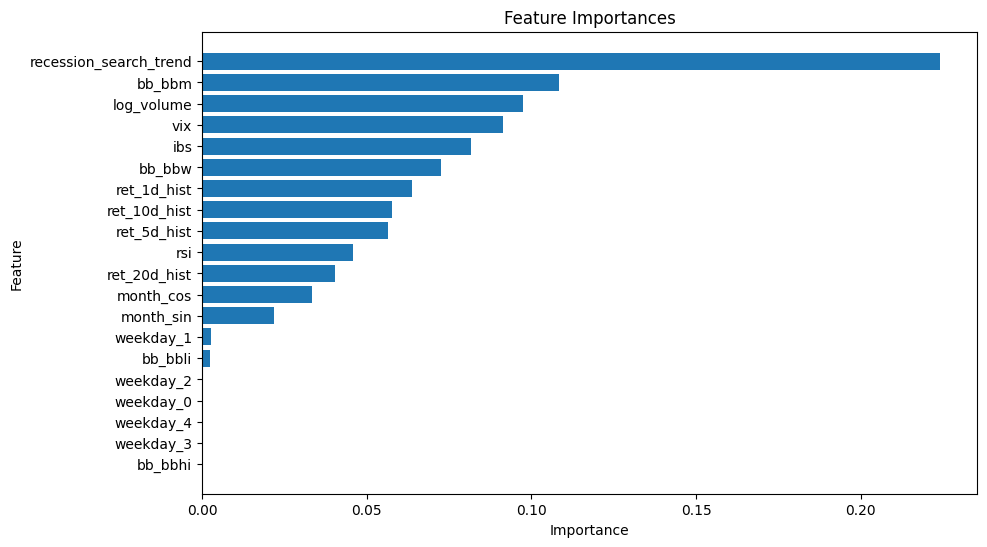

In [70]:
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


Create a new training set named `X_train_val_reduced` and a new testing set named `X_test_reduced` by eliminating any features from the old train/test sets that had a feature importance of less than `0.5%`.

In [71]:
# Drop features that have an importance of 0.05% or less...
feats_to_drop = ["weekday_0", "weekday_1", "weekday_2", "weekday_3", "weekday_4", "bb_bbhi", "bb_bbli"]
X_train_val_reduced = X_train_val.drop(columns=feats_to_drop)
X_test_reduced = X_test.drop(columns=feats_to_drop)

Re-do your grid search cross-validation with the same grid of hyperparameters as before but with the **reduced** feature set.

In [72]:
model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)

search.fit(X_train_val_reduced, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [50, 75, 100, 125, 150]},
             scoring='accuracy')

In [73]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
31       0.133510      0.022170         0.071181        0.033135   
18       0.194551      0.021111         0.073581        0.011265   
26       0.132703      0.019871         0.042459        0.021122   
36       0.156985      0.045849         0.051169        0.022911   
13       0.185606      0.023674         0.073596        0.025476   

    param_max_depth  param_min_samples_leaf  param_n_estimators  \
31                3                       3                  75   
18                2                       4                 125   
26                3                       2                  75   
36                3                       4                  75   
13                2                       3                 125   

                                               params  split0_test_score  \
31  {'max_depth': 3, 'min_samples_leaf': 3, 'n_est...           0.442522   
18  {'max_depth': 2, 'min_samples_leaf': 4, 'n_est...           0.443758   
26  {'max_depth': 3, 'min_samples_leaf': 2, 'n_est...           0.442522   
36  {'max_depth': 3, 'min_samples_leaf': 4, 'n_est...           0.442522   
13  {'max_depth': 2, 'min_samples_leaf': 3, 'n_est...           0.443758   

    split1_test_score  split2_test_score  split3_test_score  \
31           0.355995           0.569839           0.569307   
18           0.370828           0.569839           0.569307   
26           0.354759           0.569839           0.569307   
36           0.355995           0.569839           0.569307   
13           0.369592           0.569839           0.569307   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
31           0.599010         0.507335        0.093012                1  
18           0.582921         0.507331        0.085014                2  
26           0.599010         0.507087        0.093415                3  
36           0.597772         0.507087        0.092769                4  
13           0.582921         0.507083        0.085411                5

In [74]:
search.best_params_

{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 75}

Train a new classifier on the reduced feature set with the best hyperparameters combination from the new grid search and then inspect its accuracy on the test set (with the **reduced** feature set).

In [75]:
clf = search.best_estimator_
clf.fit(X_train_val_reduced, y_train_val)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, n_estimators=75,
                       n_jobs=-1, random_state=42)

In [76]:
y_test_pred = clf.predict(X_test_reduced)
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
}
display(evaluation)

{'accuracy': 0.5568743818001978,
 'precision': 0.5760111576011158,
 'recall': 0.7414721723518851,
 'f1': 0.6483516483516484}

In [77]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.51      0.33      0.40       454
           1       0.58      0.74      0.65       557

    accuracy                           0.56      1011
   macro avg       0.54      0.54      0.52      1011
weighted avg       0.55      0.56      0.54      1011



In [78]:
confusion_matrix(y_test, y_test_pred)

array([[150, 304],
       [144, 413]])

How does the accuracy compare to your last trained model?

In [79]:
answer = "We've increased the accuracy of the model vs the baseline and the previous model. This means that the features that were dropped were not very important for the model. Small differences in performance can have an 'alpha' in the market"

How does the accuracy compare to the baseline?

In [80]:
answer = "Slightly better than the benchmark. Not as good as it could be but in finance, if leveraged this could be relatively significant."

Take a look at the classification report and confusion matrices on the **training data** with the **reduced feature set** as well:

In [81]:
y_train_val_pred = clf.predict(X_train_val_reduced)
print(classification_report(y_train_val, y_train_val_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.79      0.11      0.19      1740
           1       0.59      0.98      0.74      2303

    accuracy                           0.60      4043
   macro avg       0.69      0.54      0.47      4043
weighted avg       0.68      0.60      0.50      4043



In [82]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[ 190, 1550],
       [  49, 2254]])

What would your next course of action be? In particular, share your thoughts on the following:
- Further optimization of this model
- Pursuing a different trading strategy or market (instruments) altogether
- Anything else?

In [83]:
answer = "Exploring other ML model could be better (e.g. XGBoost, LightGBM, etc.). Even trying a neural network could be a good idea. Also, feature engineering could be improved. The model could be improved by adding more features or by using a different model."

What do you think of the fact that we used interpolated **monthly** Google Trends data to try and predict short-term (5-day) price movements? 

In [84]:
answer = "It's quite possible that it's a coarse feature. In case that more granularity is selected (or the model aims at predicting monthly movements, an improvement could be seen"

## Conclusion

These results highlight the challenges in consistently training AI/ML models that outperform naive baseline scores in financial markets due to factors such as non-stationary data, low signal-to-noise ratio, high market efficiency, and a competitive and adversarial trading environment. It would be necessary to gather much more data (and higher quality data) than we have in this project, and to engineer much more complex features and models to eke out even a slight gain in performance. It is therefore essential to use your domain knowledge, have realistic expectations, and constantly monitor your modeling assumptions and metrics. We hope that this project enables you to do so by giving you the tools, techniques and ideas to keep in mind.